In [0]:
%matplotlib inline
import numpy as np
import matplotlib

from utils import plot_stroke

In [0]:
strokes = np.load('data/strokes.npy')      # loads the input stroke data, size : (6000,<seq_length>,3)
with open('data/sentences.txt') as f:
    texts = f.readlines()                  # loads the corresponding text label, size : (6000,<sentence_length>)

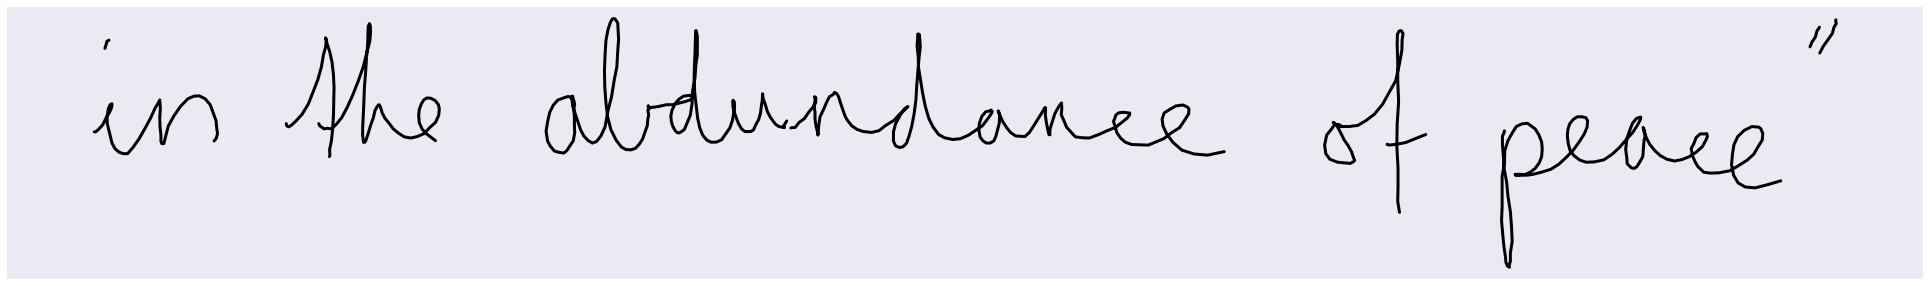

TEXT: in the abundance of peace"



In [4]:
idx = 0
stroke = strokes[idx]
text = texts[idx]
plot_stroke(stroke)
print 'TEXT:', text

In [5]:
print strokes.shape
print strokes[12].shape
print len(texts)

(6000,)
(452, 3)
6000


In [6]:
max = 0
min = 10000 # randomly chosen upperbound
index_max = 0
index_min = 0
for i,stroke in enumerate(strokes):
    if max < len(stroke):             # maximum stroke length in 1191
        max = len(stroke)
        index_max = i
    if min > len(stroke):             # minimum stroke length is 301
        min = len(stroke)
        index_min = i
print max,index_max
print min,index_min

1191 4440
301 893


In [7]:
max = 0
index = 0
for i,text in enumerate(texts):
    if max < len(text):
        max = len(text)                     # maximum text length is 65
        index = i
print max,index

65 2448


In [0]:
seq_len = []
strokes_array = np.ndarray(dtype = int, shape = (len(strokes),1200,3))
for i,stroke in enumerate(strokes):
    seq_len.append(len(stroke))                           # a list of all the stroke sequence lengths
    for _ in range(1200-len(stroke)):                     # making all the stroke inputs of uniform length 1200
        stroke = np.vstack((stroke, [[1,0,0]]))             # As the LSTM model is unrolled for 1200 timesteps
    strokes_array[i] = stroke

In [0]:
num = np.zeros(1000)                                # 1000 is chosen arbitrarily just as an upperbound to compute the
for text in texts:                                  # dictionaries for character encodings and decodings
    for ch in text:
        if num[ord(ch)] == 0 :
            num[ord(ch)] = 1
char_decoding = []
for ch_num,x in enumerate(num) :
    if x == 1 :
        char_decoding.append(ch_num)
char_encoding = {}
for i,ch_num in enumerate(char_decoding) :
    char_encoding[ch_num] = i

In [0]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

text_num_array = []
for text in texts :
    temp = []
    for ch in text :                                               
        temp.append(char_encoding[ord(ch)])         # sentences are converted into lists of values
    text_num_array.append(temp)

In [11]:
len(char_encoding)

78

In [0]:
from sklearn.model_selection import train_test_split
random_seed = 2
# Split the train and the validation set for the fitting
X_train, X_val, train_seq_len, test_seq_len, text_train, text_val = train_test_split(strokes_array, seq_len, text_num_array, test_size = 0.1, random_state=random_seed)

In [0]:
timesteps = 1200                     # As we are training an LSTM model, the number of timesteps are made uniform
hidden_dim = 10
epochs = 10
batch_size = 10
#input_dims = len(char_encoding)
output_dim = len(char_encoding) + 1
bias = 0

In [0]:
def sparse_tuple_from(sequences, dtype=np.int32):
    indices = []
    values = []

    for n, seq in enumerate(sequences):
        indices.extend(zip([n]*len(seq), range(len(seq))))
        values.extend(seq)

    indices = np.asarray(indices, dtype=np.int64)
    values = np.asarray(values, dtype=dtype)
    shape = np.asarray([len(sequences), np.asarray(indices).max(0)[1]+1], dtype=np.int64)

    return indices, values, shape

In [15]:
import tensorflow as tf
g1 = tf.Graph()
with g1.as_default():
    with tf.variable_scope("Handwriting_Prediction") :
        seq_len = tf.placeholder(tf.int32, [batch_size])
        stroke_input = tf.placeholder(tf.float32, [batch_size, timesteps, 3])

        labels = tf.sparse_placeholder(tf.int32)
        initializer = tf.contrib.layers.xavier_initializer()

        stroke_list = tf.transpose(stroke_input, perm = [1,0,2])   

        inputs = tf.unstack(value = stroke_list, axis = 0)

        with tf.variable_scope("Recurrent_Connections") :
            cell_fwd = tf.contrib.rnn.LSTMCell(hidden_dim, 3, initializer=initializer)                          # 1 layer BiLSTM
            cell_bkd = tf.contrib.rnn.LSTMCell(hidden_dim, 3, initializer=initializer)
            initial_state_fwd = cell_fwd.zero_state(batch_size, tf.float32)
            initial_state_bkd = cell_bkd.zero_state(batch_size, tf.float32)
            outputs_fw_bw, states_fw, state_bw = tf.contrib.rnn.stack_bidirectional_rnn(cells_fw = [cell_fwd], cells_bw = [cell_bkd], inputs = inputs, initial_states_fw=[initial_state_fwd], initial_states_bw=[initial_state_bkd], scope="Stacked_BiLSTM", sequence_length=seq_len)
      

      
        with tf.variable_scope("Dense_Connections") :
            output_w = tf.get_variable(name = "output_weight", dtype=tf.float32, shape=[2*hidden_dim, output_dim])
            output_b = tf.get_variable(name = "output_bias", dtype=tf.float32, shape=[output_dim])
            output_list = tf.reshape(tf.nn.xw_plus_b( tf.reshape(outputs_fw_bw, [-1,2*hidden_dim]) , output_w, output_b), [-1,batch_size,output_dim])
      
            loss = tf.reduce_sum(tf.nn.ctc_loss(labels, output_list, seq_len))                 # uses CTC loss

            decoded, log_prob = tf.nn.ctc_greedy_decoder(output_list, seq_len) # tf.contrib.ctc.ctc_beam_search_decoder is slower but provides better decoding

            ler = tf.reduce_mean(tf.edit_distance(tf.cast(decoded[0], tf.int32),labels))

    
        with tf.name_scope('training'):
            steps = tf.Variable(0.)
            learning_rate = tf.train.exponential_decay(0.001, steps, staircase=True, decay_steps=10000, decay_rate=0.5)
            optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            grad, var = zip(*optimizer.compute_gradients(loss))
            grad, _ = tf.clip_by_global_norm(grad, 1.)
            train_step = optimizer.apply_gradients(zip(grad, var), global_step=steps)
    
    
    iop = tf.initialize_all_variables()
    saver = tf.train.Saver()
    print "done"

Instructions for updating:
Use `tf.global_variables_initializer` instead.
done


In [0]:
session = tf.Session(graph = g1)
session.run(iop)
num_batches = len(X_train) // batch_size

for i in range(epochs) :  
    for batch in range(num_batches):
        batch_input = X_train[batch*batch_size : (batch+1)*batch_size,:timesteps,:]
        feed = {stroke_input: batch_input.astype('float32'), seq_len : train_seq_len[batch*batch_size : (batch+1)*batch_size], labels: sparse_tuple_from(text_train)}
        _, l = session.run([train_step, loss], feed_dict=feed)

        if batch%10==0 :
            print("    prediction_loss :"+str(pl)+"    crossentropy_loss :"+str(cl)+"    total_loss :"+str(l))
    print("-------------------------epoch : "+str(i))
  
    if i%10 == 9:
        save_path = saver.save(session, "Checkpoints/Recognition_model.ckpt")
        print("Model saved in path: %s" % save_path)